# Image Classification Without Image Augmentation

In this Google Colab notebook, I would like to build a model and train with small image dataset. 

First I will import required packages and libraries.


# Importing packages

In [0]:
import TensorFlow
import Foundation
import Python
import Time

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let subprocess = Python.import("subprocess")
let plt = Python.import("matplotlib.pyplot")
let os = Python.import("os")
let np = Python.import("numpy")  // Make numpy available using np.
let glob = Python.import("glob")
let pil = Python.import("PIL")

To build our image classifier, we begin by downloading the dataset. For this exercise, I had downloaded two class image dataset from Kaggle and used the data. To download the data, please use the following link: <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Image Database</a>

In [0]:
public extension String {
    @discardableResult
    func shell(_ args: String...) -> String {
        let (task, pipe) = (Process(), Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments, task.standardOutput) = (args, pipe)
        do    { try task.run() }
        catch { print("Unexpected error: \(error).") }

        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

In [0]:
print("/bin/ls".shell("-lh"))

We'll now download and unzip the dataset using `subprocess` library via Python Interoperability.

In [0]:
let command = "wget -nv -O- https://github.com/anigasan/GCI/tree/master/data_augmentation/cats_and_dogs_filtered.tar.gz | tar xzf - -C ."
subprocess.call(command, shell: true)

In [0]:
print("/bin/ls/".shell("-lh"))

total 8.0K
drwxr-x--- 4  501 staff 4.0K Sep 23  2016 cats_and_dogs_filtered
drwxr-xr-x 1 root root  4.0K Jan 13 16:38 sample_data



# Separate cats and dogs images

In [0]:
let catTrainList = glob.glob("cats_and_dogs_filtered/train/cats/*.jpg")
let dogTrainList = glob.glob("cats_and_dogs_filtered/train/dogs/*.jpg")
let trainList = glob.glob("cats_and_dogs_filtered/train/**/*.jpg")

let catTestList  = glob.glob("cats_and_dogs_filtered/validation/cats/*.jpg")
let dogTestList  = glob.glob("cats_and_dogs_filtered/validation/dogs/*.jpg")
let testList  = glob.glob("cats_and_dogs_filtered/validation/**/*.jpg")

for i in 0 ..< 5 {
    np.random.shuffle(trainList)
    np.random.shuffle(testList)
}

In [0]:
// to get tensor for image

func tensor(path: String) -> (Tensor<Float>, Int32) {
    let img = pil.Image.open(path)
    var image = np.array(img, dtype: np.float32) * (1.0 / 255)
    var imageTensor = Tensor<Float>(numpy: image)!
    imageTensor = imageTensor.expandingShape(at: 0)
    imageTensor = Raw.resizeArea(images: imageTensor , size: [150, 150])
    
    let label: Int32 = path.contains("dog.") ? 0 : 1
    
    return (imageTensor, label)
}


func tensors(fromList: PythonObject, valueCount: Int) -> (Tensor<Float>, Tensor<Int32>) {
    let batchFiles = fromList[0..<valueCount]
    var labels = [Int32]()
    var x: Tensor<Float>
    var y: Tensor<Int32>
    var start: Int

    // Load first image.
    let path: String = String(batchFiles[0]) ?? ""
    let data = tensor(path: path)
    x = data.0
    labels.append(data.1)

    // Load rest of the images.
    var numberOfFilesDone = 1
    for file in batchFiles[1..<valueCount] {
        let path = String(file) ?? ""
        let data = tensor(path: path)
        let tensor = data.0
        labels.append(data.1)
        x = Tensor(concatenating: [x, tensor], alongAxis: 0)
        numberOfFilesDone += 1
        if numberOfFilesDone.isMultiple(of: 10) {
            print("", (numberOfFilesDone), separator: " ", terminator:"")
        }
        if numberOfFilesDone.isMultiple(of: 100) {
            print("")
        }
    }
    print("")
    y = Tensor<Int32>(labels)
    return (x, y)
}

Creating **trainTensors** and **testTesnors**

In [0]:
let trainTensors = tensors(fromList: trainList, valueCount: trainList.count)
let trainImageTensors = trainTensors.0
let trainLabelTensors = trainTensors.1
print(trainImageTensors.shape)
print(trainLabelTensors.shape)
let testTensors = tensors(fromList: testList, valueCount: testList.count)
let testImageTensors = testTensors.0
let testLabelTensors = testTensors.1


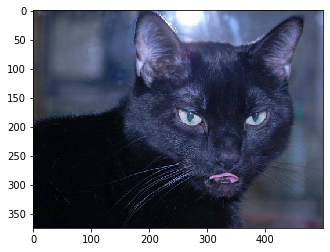

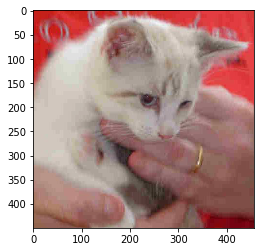

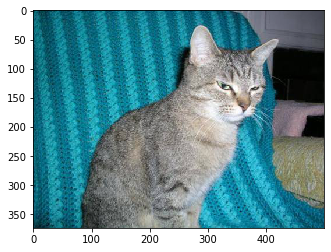

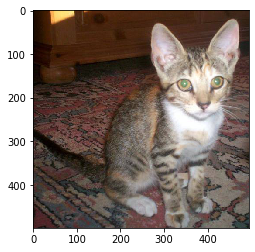

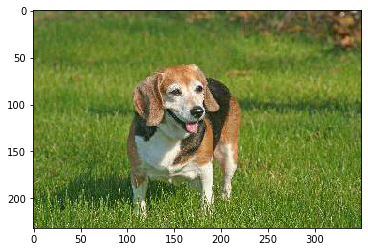

In [0]:
let images = trainList[0..<5]
for i in 0..<5 {
    plotImages(from: String(images[i])!)
}

# Model Creation

## Define the model

Build a model with 5 layers and with output of two classes (cats and dogs)

In [0]:
struct Classifier: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var conv1a = Conv2D<Float>(filterShape: (3, 3, 3, 32), activation: relu)
    var pool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1b = Conv2D<Float>(filterShape: (3, 3, 32, 64), activation: relu)
    var pool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1c = Conv2D<Float>(filterShape: (3, 3, 64, 128), activation: relu)
    var pool3 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    var drop1 = Dropout<Float>(probability: 0.5)
    
    var conv1d = Conv2D<Float>(filterShape: (3, 3, 128, 128), activation: relu)
    var pool4 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var flatten = Flatten<Float>()
    var layer1a = Dense<Float>(inputSize: 6272, outputSize: 512, activation: relu)
    var layer1b = Dense<Float>(inputSize: 512, outputSize: 2, activation: softmax)

    @differentiable
    public func callAsFunction(_ input: Input) -> Output {
        var convolved1 = input.sequenced(through: conv1a, pool1)
        var convolved2 = convolved1.sequenced(through: conv1b, pool2)
        var convolved3 = convolved2.sequenced(through: conv1c, pool3, drop1)
        var convolved4 = convolved3.sequenced(through: conv1d, pool4)
        return convolved4.sequenced(through: flatten, layer1a, layer1b)
    }
}

### Compile the model

Compile the model with adam optimizer and input shape of 150 x 150  x 3

In [0]:
let tensor = Tensor<Float>(zeros:[100, 150, 150, 3])
var classifier = Classifier()
var optimizer = Adam(for: classifier, learningRate: 0.001)
classifier(tensor).shape

Setting epoch count to 100 and batch size = 100

In [0]:
let epochCount = 100
let batchSize = 100

print(DispatchTime.now())

// Extract a batch of size batchSize.
func minibatch<Scalar>(in x: Tensor<Scalar>, at index: Int) -> Tensor<Scalar> {
    let start = index * batchSize
    return x[start..<start+batchSize]
}

In [0]:
var trainingAccuracy: [Float] = []
var validationAccuracy: [Float] = []
var trainingLoss: [Float] = []
var validationLoss: [Float] = []
var epochsRange: [Int] = []

### Train the model

It's time to train our network. 

In [0]:
print("Let the training begin...")

struct Statistics {
    var correctGuessCount: Int = 0
    var totalGuessCount: Int = 0
    var totalLoss: Float = 0
}

// The training loop.
for epoch in 1...epochCount {
    epochsRange.append(epoch)
    var trainStats = Statistics()
    var testStats = Statistics()
    var ebegin = DispatchTime.now() // To measure time taken
    Context.local.learningPhase = .training
    for i in 0..<Int(trainList.count) / batchSize {
        let x = minibatch(in: trainImageTensors, at: i)
        let y = minibatch(in: trainLabelTensors, at: i)
        // Compute the gradient with respect to the model.
        let 𝛁model = classifier.gradient { classifier -> Tensor<Float> in
            let ŷ = classifier(x)
            let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
            trainStats.correctGuessCount += Int(
              Tensor<Int32>(correctPredictions).sum().scalarized())
            trainStats.totalGuessCount += batchSize
            let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
            trainStats.totalLoss += loss.scalarized()
            return loss
        }
        // Update the model's differentiable variables along the gradient vector.
        optimizer.update(&classifier, along: 𝛁model)
    }

    Context.local.learningPhase = .inference
    for i in 0..<Int(testList.count) / batchSize {
        let x = minibatch(in: testImageTensors, at: i)
        let y = minibatch(in: testLabelTensors, at: i)
        // Compute loss on test set.
        let ŷ = classifier(x)
        let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
        testStats.correctGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())
        testStats.totalGuessCount += batchSize
        let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
        testStats.totalLoss += loss.scalarized()
    }
    
    var eend = DispatchTime.now()
    let trainAccuracy = Float(trainStats.correctGuessCount) / Float(trainStats.totalGuessCount)
    let testAccuracy = Float(testStats.correctGuessCount) / Float(testStats.totalGuessCount)
    
    trainingAccuracy.append(trainAccuracy)
    validationAccuracy.append(testAccuracy)
    trainingLoss.append(trainStats.totalLoss)
    validationLoss.append(testStats.totalLoss)

    let nanoTime = eend.uptimeNanoseconds - ebegin.uptimeNanoseconds
    let epochTime = Double(nanoTime) / 1_000_000_000    
    print("""
          [Epoch \(epoch)] \
          Time Taken: \(epochTime), \
          Train Loss: \(trainStats.totalLoss), \
          Train Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \ 
          (\(trainAccuracy)), \
          Test Loss: \(testStats.totalLoss), \
          Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
          (\(testAccuracy))
          """)
}

### Visualizing results of the training

Plotting the results of the training

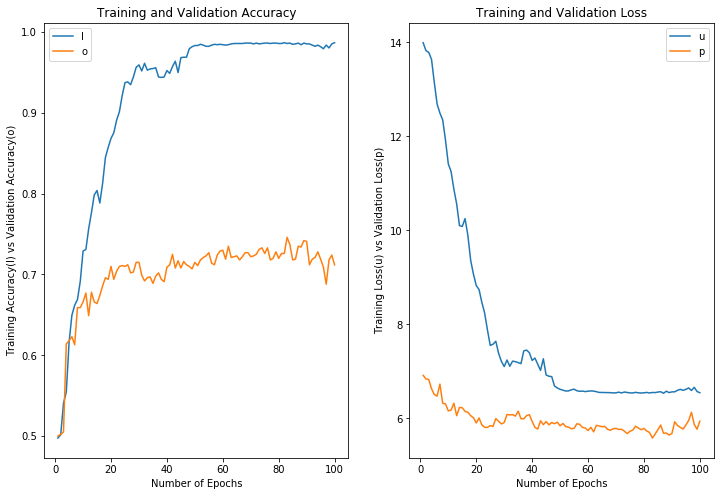

None


In [0]:
plt.figure(figsize: [12, 8])
plt.subplot(1, 2, 1)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy(l) vs Validation Accuracy(o)")
plt.plot(epochsRange, trainingAccuracy)
plt.plot(epochsRange, validationAccuracy)
var loc = "lower right"
plt.legend(loc)
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss(u) vs Validation Loss(p)")
plt.plot(epochsRange, trainingLoss)
plt.plot(epochsRange, validationLoss)
loc = "upper right"
plt.legend(loc)
plt.title("Training and Validation Loss")
plt.show()

 As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around **70%** accuracy on the validation set (depending on the number of epochs you trained for).

